## Простое обучение

### Подгружаем нужные библиотеки

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np

import matplotlib.pyplot as plt

import subprocess

import random

### Качаем данные

In [9]:
# Функция для скачивания и извлечения датасета
def download_and_extract_dataset(url, target_path):
    subprocess.run(['wget', url])
    subprocess.run(['tar', 'xfz', 'petfaces.tar'])
    subprocess.run(['rm', 'petfaces.tar'])
    print(f"Dataset extracted to {target_path}")

# URL и путь для датасета
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
target_path = 'petfaces'
download_and_extract_dataset(url, target_path)

Dataset extracted to petfaces


### Предобработка данных

In [10]:
# Предобработка данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка и разделение данных
def load_data(path):
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)
    target = [y for _, y in dataset.samples]
    train_idx, test_idx = train_test_split(np.arange(len(target)), test_size=0.2, stratify=target)

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)

    return train_dataset, test_dataset

train_dataset, test_dataset = load_data(target_path)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Обучение модели

In [11]:
class PetNet(nn.Module):
    def __init__(self):
        super(PetNet, self).__init__()
        backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.classifier = nn.Linear(backbone.fc.in_features, 36)
        self.binary_classifier = nn.Linear(backbone.fc.in_features, 2)  # бинарный классификатор для кошек и собак

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Преобразуем для линейного классификатора
        breed = self.classifier(x)
        binary = self.binary_classifier(x)
        return breed, binary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetNet().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/dr0ozd/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)>

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Тренировка модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            breed_outputs, binary_outputs = model(images)
            loss_breed = criterion(breed_outputs, labels)
            loss_binary = criterion(binary_outputs, labels % 2)  # Кошки против собак
            loss = loss_breed + loss_binary
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Запуск тренировки модели
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Loss: 0.9446992874145508
Epoch 2, Loss: 0.6154470443725586
Epoch 3, Loss: 0.4995953440666199
Epoch 4, Loss: 1.428885817527771
Epoch 5, Loss: 0.1690312922000885
Epoch 6, Loss: 0.705904483795166
Epoch 7, Loss: 0.47596052289009094
Epoch 8, Loss: 0.09617908298969269
Epoch 9, Loss: 0.14492326974868774
Epoch 10, Loss: 0.19880075752735138


### Оценка модели

In [ ]:
class_names = {
    0: 'cat_Abyssinian', 1: 'cat_Bengal', 2: 'cat_Birman', 3: 'cat_Bombay', 4: 'cat_British',
    5: 'cat_Egyptian', 6: 'cat_Maine', 7: 'cat_Persian', 8: 'cat_Ragdoll', 9: 'cat_Russian',
    10: 'cat_Siamese', 11: 'cat_Sphynx', 12: 'dog_american', 13: 'dog_basset', 14: 'dog_beagle',
    15: 'dog_boxer', 16: 'dog_chihuahua', 17: 'dog_english', 18: 'dog_german', 19: 'dog_great',
    20: 'dog_havanese', 21: 'dog_japanese', 22: 'dog_keeshond', 23: 'dog_leonberger',
    24: 'dog_miniature', 25: 'dog_newfoundland', 26: 'dog_pomeranian', 27: 'dog_pug',
    28: 'dog_saint', 29: 'dog_samoyed', 30: 'dog_scottish', 31: 'dog_shiba', 32: 'dog_staffordshire',
    33: 'dog_wheaten', 34: 'dog_yorkshire'
}

binary_names = {0: 'Cat', 1: 'Dog'}

Breed Classification Accuracy:  0.8320373250388803
Binary Classification Accuracy:  0.895800933125972


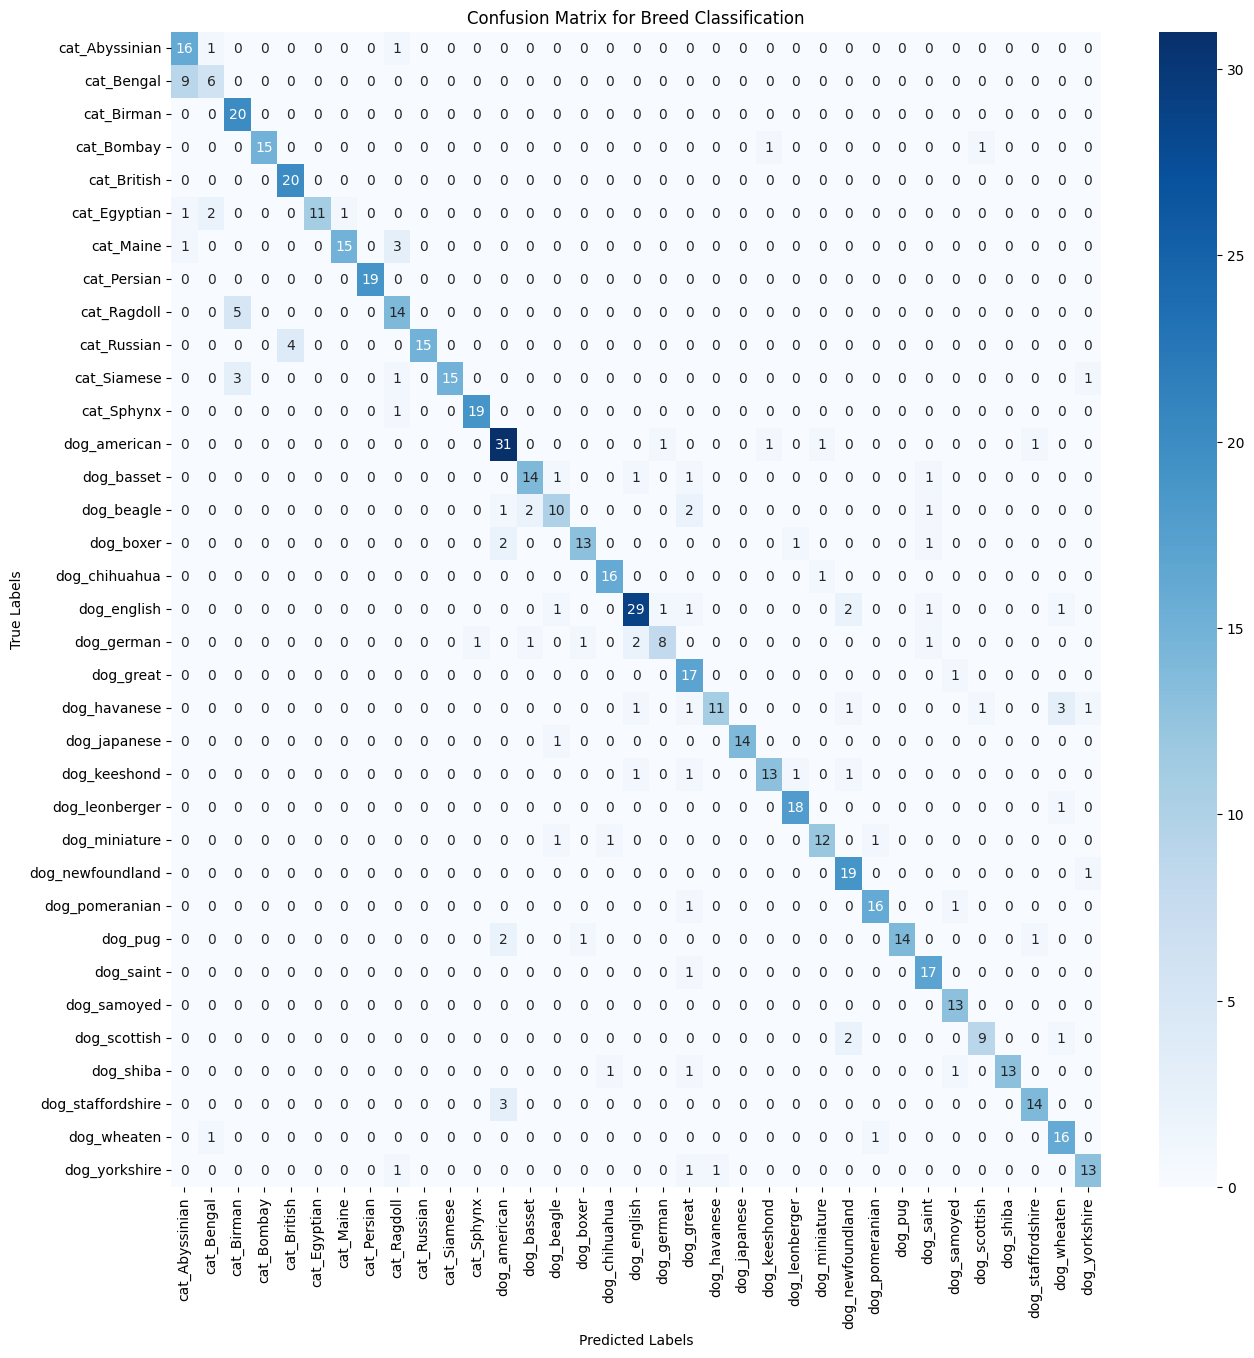

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds_breed = []
    all_preds_binary = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            breed_outputs, binary_outputs = model(images)
            _, breed_preds = torch.max(breed_outputs, 1)
            _, binary_preds = torch.max(binary_outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds_breed.extend(breed_preds.cpu().numpy())
            all_preds_binary.extend(binary_preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_breed = np.array(all_preds_breed)
    all_preds_binary = np.array(all_preds_binary)

    breed_accuracy = accuracy_score(all_labels, all_preds_breed)
    binary_accuracy = accuracy_score(all_labels % 2, all_preds_binary)

    breed_conf_matrix = confusion_matrix(all_labels, all_preds_breed)

    print("Breed Classification Accuracy: ", breed_accuracy)
    print("Binary Classification Accuracy: ", binary_accuracy)

    class_names_list = list(class_names.values())

    plt.figure(figsize=(15, 15))
    sns.heatmap(breed_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title('Confusion Matrix for Breed Classification')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

evaluate_model(model, test_loader, device)

In [ ]:
def calculate_topk_accuracy(model, loader, k=3):
    model.eval()
    correct_topk = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)[0]
            _, pred = output.topk(k, 1, True, True)
            correct_topk += pred.eq(target.view(-1, 1).expand_as(pred)).sum().item()
    topk_acc = correct_topk / len(loader.dataset)
    return topk_acc

top3_accuracy = calculate_topk_accuracy(model, test_loader, k=3)
print(f'Top-3 Accuracy: {top3_accuracy * 100:.2f}%')

Top-3 Accuracy: 95.49%


### Показ результата

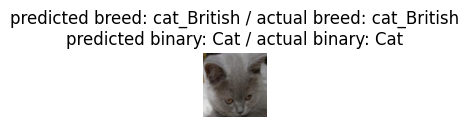

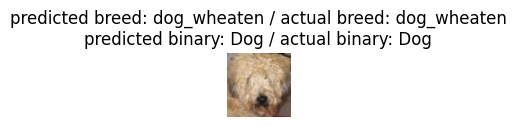

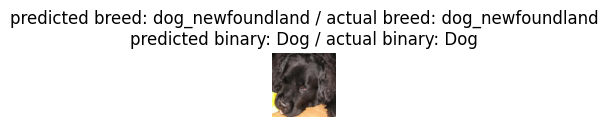

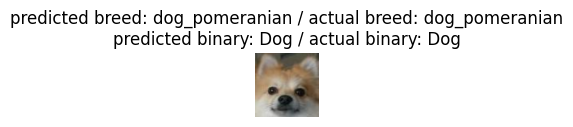

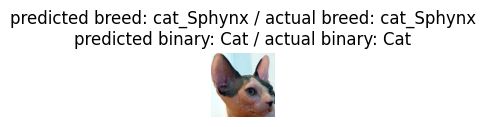

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=1):
    was_training = model.training
    model.eval()
    images_so_far = 0

    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    indices = indices[:num_images]

    with torch.no_grad():
        for i in indices:
            inputs, labels = test_dataset[i]
            inputs = inputs.unsqueeze(0).to(device)
            labels = torch.tensor([labels]).to(device)

            breed_outputs, binary_outputs = model(inputs)
            _, breed_preds = torch.max(breed_outputs, 1)
            _, binary_preds = torch.max(binary_outputs, 1)

            images_so_far += 1
            ax = plt.subplot(num_images, 1, images_so_far)
            ax.axis('off')
            predicted_breed_name = class_names[breed_preds[0].item()]
            actual_breed_name = class_names[labels[0].item()]
            predicted_binary_name = binary_names[1 if breed_preds[0].item() >= 12 else 0]
            actual_binary_name = binary_names[1 if labels[0].item() >= 12 else 0]

            ax.set_title(f'predicted breed: {predicted_breed_name} / actual breed: {actual_breed_name}\n'
                         f'predicted binary: {predicted_binary_name} / actual binary: {actual_binary_name}')
            imshow(inputs.cpu().squeeze(0))

    model.train(mode=was_training)

visualize_model(model, num_images=5)

## Обучение с новыми гиперпараметрами

### Скачиваем нужную библиотеку

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.2 MB/s eta 0:00:00


### Запуск оптимизации

In [ ]:
import optuna

def objective(trial):
    # Гиперпараметры
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_neurons = trial.suggest_categorical('num_neurons', [256, 512, 1024])
    num_layers = trial.suggest_int('num_layers', 1, 3)

    backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    layers = list(backbone.children())[:-1]  # Удаление оригинального полносвязного слоя
    layers.append(nn.Flatten())
    for i in range(num_layers):
        layers.append(nn.Linear(backbone.fc.in_features if i == 0 else num_neurons, num_neurons))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(num_neurons, 36))
    model = nn.Sequential(*layers)
    model.to(device)

    # Оптимизатор
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Обучение модели
    for epoch in range(3):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Оценка модели
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value:.4f}')
print(f'Best hyperparameters: {trial.params}')

### Результаты поиска оптимальных гиперпараметров

In [ ]:
[I 2024-04-20 16:36:07,833] A new study created in memory with name: no-name-dfdd0af4-a372-4e7d-827d-be28dbf39aac
[I 2024-04-20 17:11:03,296] Trial 0 finished with value: 0.6158631415241057 and parameters: {'lr': 0.000323804849102746, 'num_neurons': 512, 'num_layers': 3}. Best is trial 0 with value: 0.6158631415241057.
[I 2024-04-20 17:45:38,532] Trial 1 finished with value: 0.05598755832037325 and parameters: {'lr': 0.032449118605335774, 'num_neurons': 512, 'num_layers': 1}. Best is trial 0 with value: 0.6158631415241057.
[I 2024-04-20 18:20:12,157] Trial 2 finished with value: 0.3514774494556765 and parameters: {'lr': 0.0008559093880516777, 'num_neurons': 256, 'num_layers': 3}. Best is trial 0 with value: 0.6158631415241057.
[I 2024-04-20 18:54:35,254] Trial 3 finished with value: 0.05443234836702955 and parameters: {'lr': 0.004598921838520905, 'num_neurons': 512, 'num_layers': 3}. Best is trial 0 with value: 0.6158631415241057.
[I 2024-04-20 19:29:09,548] Trial 4 finished with value: 0.7822706065318819 and parameters: {'lr': 9.260874310082746e-05, 'num_neurons': 512, 'num_layers': 2}. Best is trial 4 with value: 0.7822706065318819.
[I 2024-04-20 20:03:33,595] Trial 5 finished with value: 0.5925349922239502 and parameters: {'lr': 0.00045510933270141485, 'num_neurons': 512, 'num_layers': 3}. Best is trial 4 with value: 0.7822706065318819.
[I 2024-04-20 20:38:00,095] Trial 6 finished with value: 0.05443234836702955 and parameters: {'lr': 0.09831588224738495, 'num_neurons': 1024, 'num_layers': 2}. Best is trial 4 with value: 0.7822706065318819.
[I 2024-04-20 21:12:45,695] Trial 7 finished with value: 0.05443234836702955 and parameters: {'lr': 0.02481241798601956, 'num_neurons': 1024, 'num_layers': 3}. Best is trial 4 with value: 0.7822706065318819.
[I 2024-04-20 21:46:29,509] Trial 8 finished with value: 0.9020217729393468 and parameters: {'lr': 9.319409051007874e-05, 'num_neurons': 1024, 'num_layers': 1}. Best is trial 8 with value: 0.9020217729393468.
[I 2024-04-20 22:21:09,465] Trial 9 finished with value: 0.07465007776049767 and parameters: {'lr': 0.0052896234268481794, 'num_neurons': 256, 'num_layers': 1}. Best is trial 8 with value: 0.9020217729393468.
[I 2024-04-20 22:55:26,133] Trial 10 finished with value: 0.42923794712286156 and parameters: {'lr': 1.2509270644456165e-05, 'num_neurons': 1024, 'num_layers': 1}. Best is trial 8 with value: 0.9020217729393468.
[I 2024-04-20 23:30:12,165] Trial 11 finished with value: 0.6220839813374806 and parameters: {'lr': 4.3429881877830574e-05, 'num_neurons': 1024, 'num_layers': 2}. Best is trial 8 with value: 0.9020217729393468.
[I 2024-04-21 00:05:16,657] Trial 12 finished with value: 0.8475894245723172 and parameters: {'lr': 8.530934943544062e-05, 'num_neurons': 1024, 'num_layers': 2}. Best is trial 8 with value: 0.9020217729393468.

### Новое обучение

In [ ]:
class OptimalPetNet(nn.Module):
    def __init__(self):
        super(OptimalPetNet, self).__init__()
        # Загрузка предобученной сети ResNet18
        backbone = models.resnet18(pretrained=True)
        # Удаление последнего полносвязного слоя
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        # Добавление нового полносвязного слоя с 1024 нейронами
        self.classifier = nn.Linear(backbone.fc.in_features, 1024)
        self.final_classifier = nn.Linear(1024, 36)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.final_classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimalPetNet().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=9.319409051007874e-05)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Тренировка модели
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Loss: 1.6740648746490479
Epoch 2, Loss: 0.6631331443786621
Epoch 3, Loss: 0.6143361330032349
Epoch 4, Loss: 0.30060261487960815
Epoch 5, Loss: 0.2011934220790863
Epoch 6, Loss: 0.03420332074165344
Epoch 7, Loss: 0.04816805198788643
Epoch 8, Loss: 0.5075727105140686
Epoch 9, Loss: 0.2004612386226654
Epoch 10, Loss: 0.06026071682572365


### Оценка

Overall Classification Accuracy: 90.82%
Binary Classification Accuracy (Cats vs Dogs): 99.84%


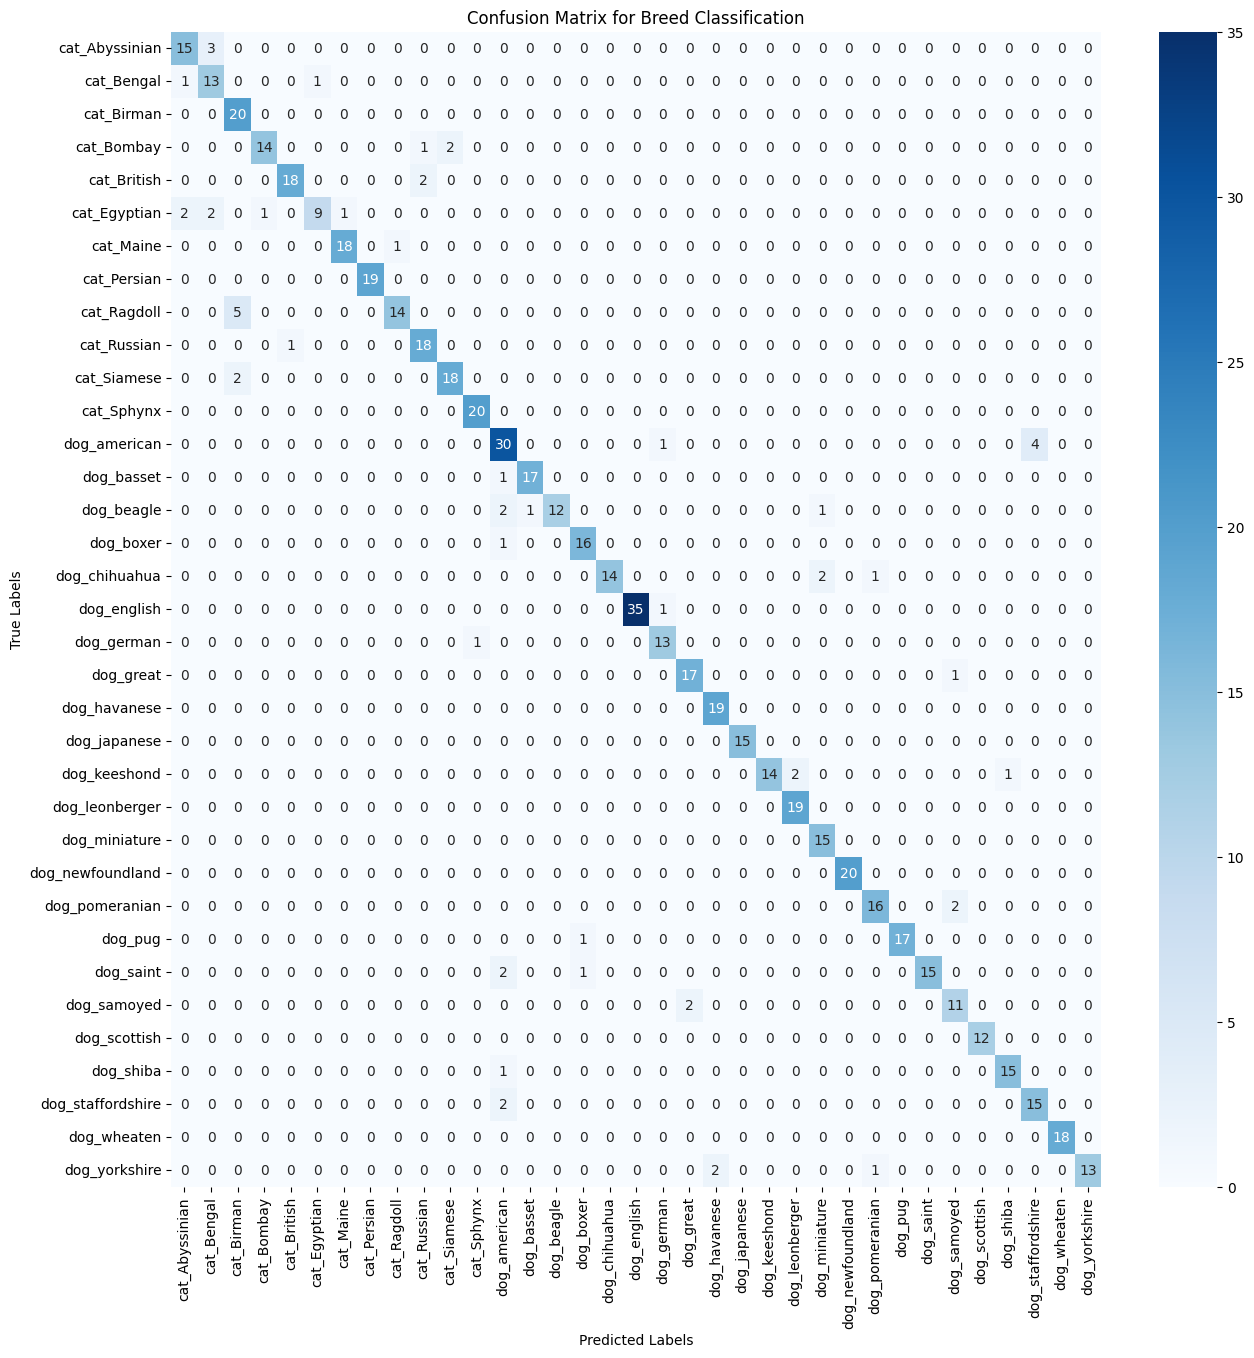

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_binary_labels = []
    all_binary_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            binary_labels = (labels >= 12).long()
            binary_preds = (preds >= 12).long()
            all_binary_labels.extend(binary_labels.cpu().numpy())
            all_binary_preds.extend(binary_preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    binary_accuracy = accuracy_score(all_binary_labels, all_binary_preds)
    breed_conf_matrix = confusion_matrix(all_labels, all_preds)
    binary_conf_matrix = confusion_matrix(all_binary_labels, all_binary_preds)

    print(f"Overall Classification Accuracy: {accuracy * 100:.2f}%")
    print(f"Binary Classification Accuracy (Cats vs Dogs): {binary_accuracy * 100:.2f}%")

    class_names_list = list(class_names.values())

    plt.figure(figsize=(15, 15))
    sns.heatmap(breed_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title('Confusion Matrix for Breed Classification')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return accuracy, binary_accuracy, breed_conf_matrix

accuracy, binary_accuracy, breed_conf_matrix = evaluate_model(model, test_loader)

In [ ]:
def calculate_topk_accuracy(model, test_loader, k=3):
  model.eval()
  correct_topk = 0.0
  total = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, pred = output.topk(k, 1, True, True)
      correct_topk += pred.eq(target.view(-1, 1).expand_as(pred)).sum().item()
      total += target.size(0)
  topk_accuracy = correct_topk / total
  print(f"Top-{k} Accuracy: {topk_accuracy * 100:.2f}%")
  return topk_accuracy

top3_accuracy = calculate_topk_accuracy(model, test_loader, k=3)

Top-3 Accuracy: 98.13%


### Вывод результата

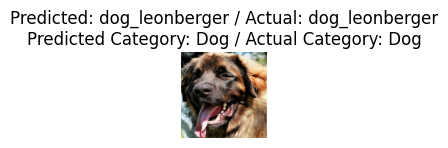

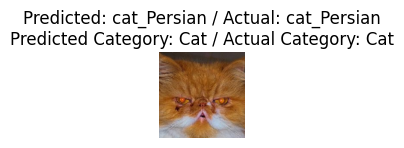

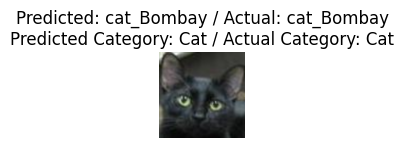

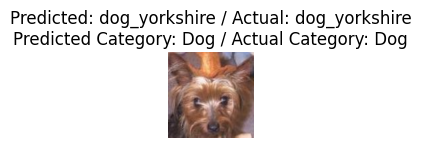

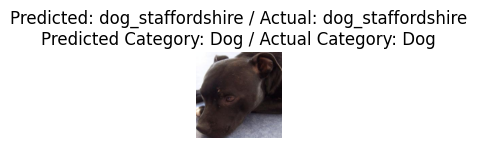

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def visualize_model(model, num_images=1):
    was_training = model.training
    model.eval()
    images_so_far = 0

    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    indices = indices[:num_images]

    with torch.no_grad():
        for i in indices:
            inputs, labels = test_dataset[i]
            inputs = inputs.unsqueeze(0).to(device)
            labels = torch.tensor([labels]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            images_so_far += 1
            ax = plt.subplot(1, num_images, images_so_far)
            ax.axis('off')
            predicted_breed_name = class_names[preds[0].item()]
            actual_breed_name = class_names[labels[0].item()]
            predicted_binary_category = binary_names[0 if preds[0].item() < 12 else 1]
            actual_binary_category = binary_names[0 if labels[0].item() < 12 else 1]

            ax.set_title(f'Predicted: {predicted_breed_name} / Actual: {actual_breed_name}\n'
                         f'Predicted Category: {predicted_binary_category} / Actual Category: {actual_binary_category}')
            imshow(inputs.cpu().squeeze(0))

    model.train(mode=was_training)

visualize_model(model, num_images=5)

## Выводы

Процесс оптимизации гиперпараметров значительно улучшил производительность модели по всем ключевым метрикам. Особенно стоит отметить улучшение в бинарной классификации, где точность приблизилась к идеальной.